## Saving and loading models, with application to the EuroSat dataset

This project will create a neural network that classifies land uses and land covers from satellite imagery. It will save the model using Tensorflow's callbacks and reload it later. It will also load in a pre-trained neural network classifier and compare performance with it.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell.

## Credits
Some of the material in this notebook has been taken from the Jupyter notebooks provided in the CS 479 Course instructed by Dr. Gurman Gill.

In [1]:
#### PACKAGE IMPORTS ####
# Run this cell first to import all required packages.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.src import Model

In [2]:
# This cell REQUIRED if running on Colab
# Comment this cell if NOT running on Colab

# Download the dataset (data.zip) containing training and test images
!gdown --id 1wCT5kTQfViAzD9yr27L172oMjEIX0rxV

# Download the overview image (eurosat_overview_small.jpeg)
!gdown --id 19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wCT5kTQfViAzD9yr27L172oMjEIX0rxV
To: /content/data.zip
100% 60.7M/60.7M [00:01<00:00, 43.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf
To: /content/eurosat_overview_small.jpeg
100% 187k/187k [00:00<00:00, 120MB/s]


In [3]:
# Unzip the dataset
data_dir = "data.zip"

# Unzip the dataset if not already done
if not os.path.exists("data"):
  !unzip "$data_dir"

Archive:  data.zip
   creating: data/
  inflating: data/y_train.npy        
  inflating: data/x_test.npy         
  inflating: data/x_train.npy        
  inflating: data/y_test.npy         


#### The EuroSAT dataset

This project, will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake.


---
![Overview of Eurosat dataset](https://drive.google.com/uc?id=19j5hPsSKVbHU1ptW_Ro11jycd-rkPEvf)

For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

The goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some saving and loading techniques. In addition, it will apply transfer learning to perform classification on this dataset.

#### Import the data

The dataset that will train the model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class.
The train and test datasets required for this project are stored in the `data` folder.

The datasets will be loaded below into variables `x_train`, `y_train`, `x_test`, `y_test`.

In [4]:
# Import the Eurosat data from local folder. Assuming it is placed in a data folder relative to this notebook.
def load_eurosat_data():
    x_train = np.load('data/x_train.npy')
    y_train = np.load('data/y_train.npy')
    x_test  = np.load('data/x_test.npy')
    y_test  = np.load('data/y_test.npy')
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_eurosat_data()

# Pre-process images
x_train = x_train / 255.0
x_test = x_test / 255.0

print("{} training data examples".format(x_train.shape[0]))
print("{} test data examples".format(x_test.shape[0]))

print("Shape of first training image: {}".format(x_train[0].shape))
print("Training label of first training image: {}".format(y_train[0]))

4000 training data examples
1000 test data examples
Shape of first training image: (64, 64, 3)
Training label of first training image: [2]


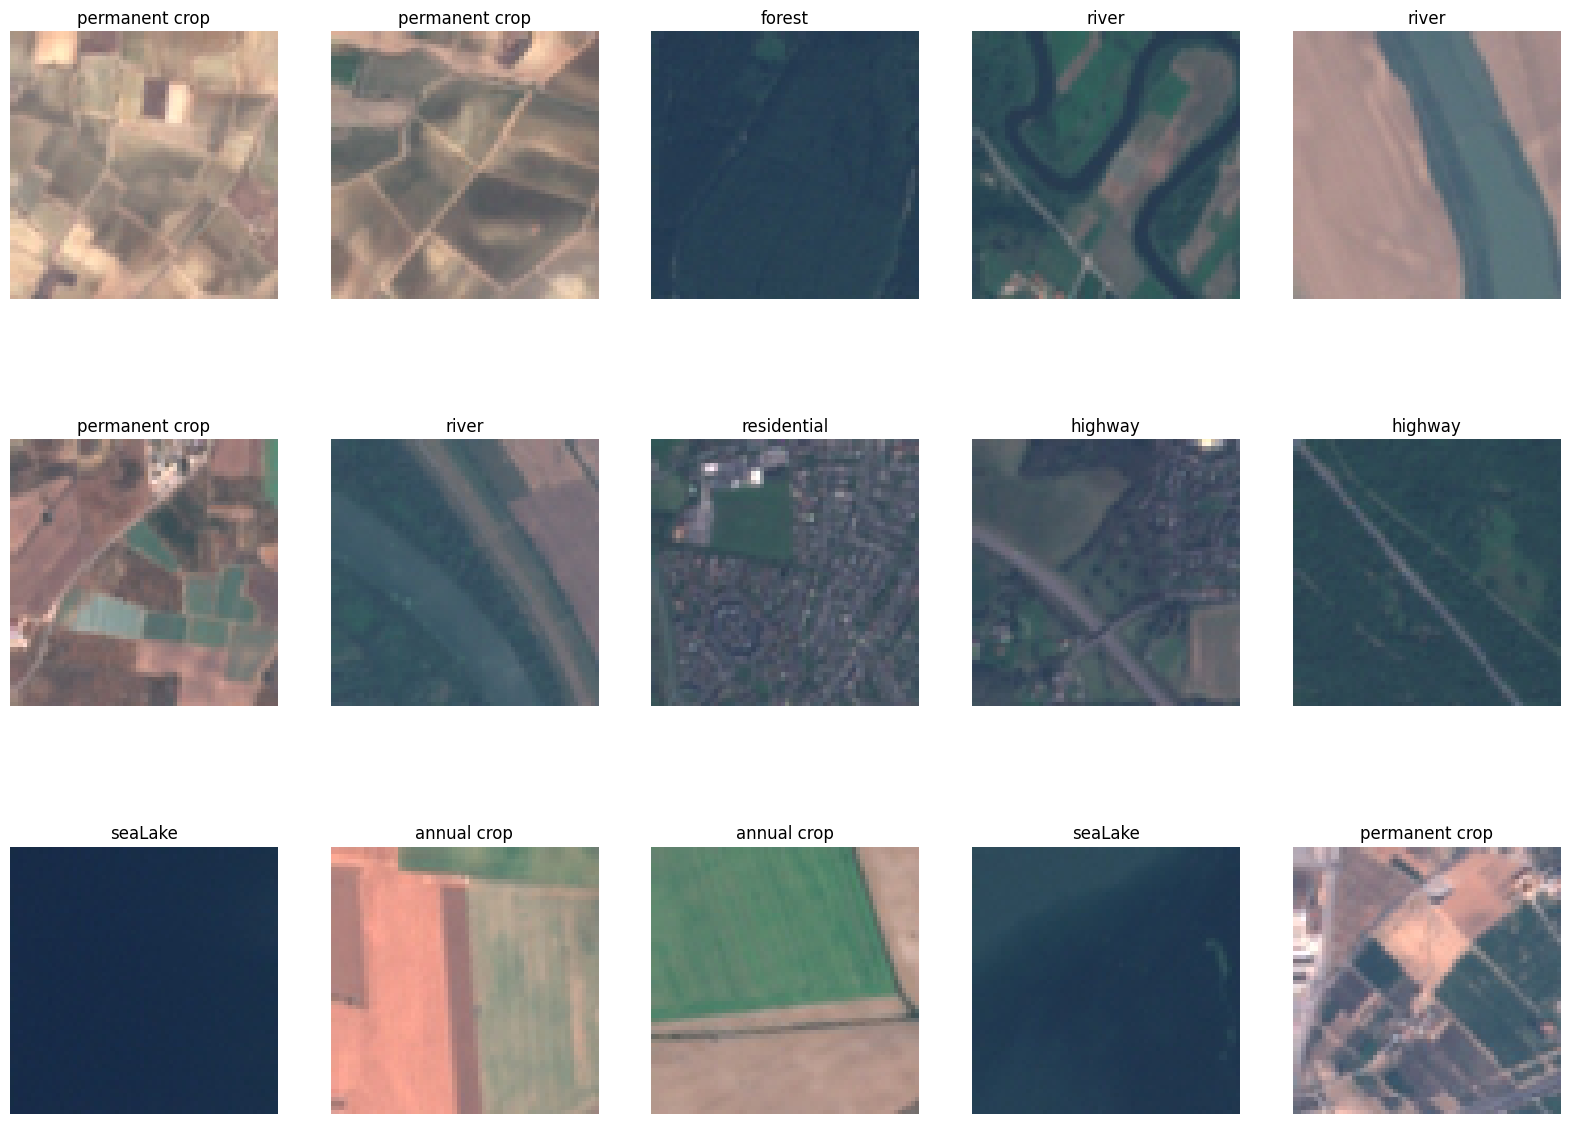

In [5]:
# Display a few images and labels
# Run this cell multiple times to get flavor of the kind of images in this dataset
class_names = ['annual crop', 'forest', 'herbaceous vegetation', 'highway',  'industrial',   'pasture',
                         'permanent crop', 'residential', 'river', 'seaLake']

plt.figure(figsize=(20,15))
inx = np.random.choice(x_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

In [6]:
# Show the number of each class of images
for i in range(10):
    print(f"Number of images with class label {class_names[i]} = {np.sum(y_train == i)}")

Number of images with class label annual crop = 406
Number of images with class label forest = 400
Number of images with class label herbaceous vegetation = 394
Number of images with class label highway = 410
Number of images with class label industrial = 397
Number of images with class label pasture = 419
Number of images with class label permanent crop = 411
Number of images with class label residential = 398
Number of images with class label river = 397
Number of images with class label seaLake = 368


#### Build the neural network model

In [7]:
"""
This function will build a Sequential model according to the above specification. The
weights are initialised by providing the input_shape argument in the first layer, given by the
function argument.
The model is then compiled using the legacy Adam optimizer and uses the Sparse Categorical
Crossentropy loss function.
"""
def get_new_model(input_shape):

    # Build the Model
    model = Sequential([
        Conv2D(16, kernel_size=(3,3), activation="relu", input_shape=input_shape, padding="same", name="conv_1"),
        Conv2D(8, kernel_size=(3,3), activation="relu", padding="same", name="conv_2"),
        MaxPooling2D(pool_size=(8,8), name="pool_1"),
        Flatten(name="flatten"),
        Dense(32, activation="relu", name="dense_1"),
        Dense(10, activation="softmax", name="dense_2")
    ])

    # Compile the Model and Return
    adam = tf.keras.optimizers.legacy.Adam()
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

# Run the function to create the model
model = get_new_model(x_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 18354 (71.70 KB)
Trainable params: 18354 (

#### Evaluate the model

In [8]:
# Run this cell to define a function to evaluate a model's test accuracy
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

# Calculate its initial test accuracy (without any training)
test_init = get_test_accuracy(model, x_test, y_test)

accuracy: 0.097


#### Create checkpoints to save model during training, with a criterion

Create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. **Uses the testing data as the validation data.**
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [9]:
"""
This function will return a ModelCheckpoint object that:
- saves the weights only at the end of every epoch
- saves into a directory called 'checkpoints_every_epoch' inside the current working directory
- generates filenames in that directory like 'checkpoint_XXX' where
  XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
"""
def get_checkpoint_every_epoch():
    # Define a callback for checkpointing
    checkpoint_every_epoch = ModelCheckpoint(filepath="/checkpoint_every_epoch/checkpoint_{epoch:03d}", save_freq='epoch', save_weights_only=True, verbose=1)

    return checkpoint_every_epoch

"""
This function will return a ModelCheckpoint object that:
- saves only the weights that generate the highest validation (testing) accuracy
- saves into a directory called 'checkpoints_best_only' inside the current working directory
- generates a file called 'checkpoints_best_only/checkpoint'
"""
def get_checkpoint_best_only():
    # Define a callback for checkpointing
    checkpoint_best_only = ModelCheckpoint(filepath='/checkpoint_best_only/checkpoint', save_freq='epoch', monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1)

    return checkpoint_best_only

"""
This function will return an EarlyStopping callback that stops training when
the validation (testing) accuracy has not improved in the last 3 epochs.
Set verbose = 1.
"""
def get_early_stopping():
    # Callback for early stopping
    early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

    return early_Stopping

In [10]:
# Run this cell to create the callbacks
checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

#### Train model using the callbacks

In [11]:
# Train model using the callbacks you just created
callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/50
121/125 [============================>.] - ETA: 0s - loss: 2.0223 - accuracy: 0.2218
Epoch 1: saving model to /checkpoint_every_epoch/checkpoint_001

Epoch 1: val_accuracy improved from -inf to 0.36400, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 3s 11ms/step - loss: 2.0105 - accuracy: 0.2272 - val_loss: 1.6452 - val_accuracy: 0.3640
Epoch 2/50
122/125 [============================>.] - ETA: 0s - loss: 1.5155 - accuracy: 0.4050
Epoch 2: saving model to /checkpoint_every_epoch/checkpoint_002

Epoch 2: val_accuracy improved from 0.36400 to 0.45400, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 1s 8ms/step - loss: 1.5178 - accuracy: 0.4062 - val_loss: 1.4356 - val_accuracy: 0.4540
Epoch 3/50
114/125 [==========================>...] - ETA: 0s - loss: 1.3675 - accuracy: 0.4635
Epoch 3: saving model to /checkpoint_every_epoch/checkpoint_003

Epoch 3: val_accuracy improved from 0.45400 to 

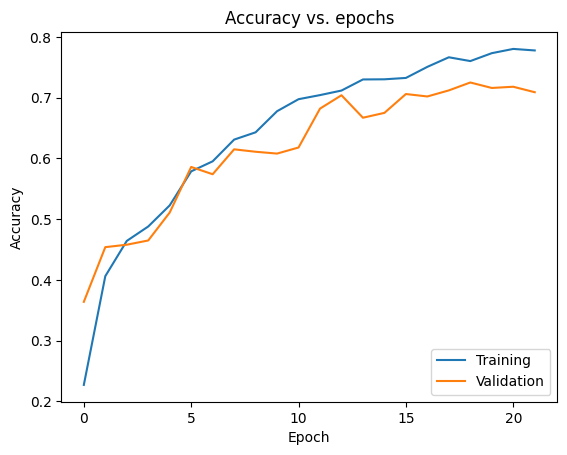

In [12]:
#Run this cell to plot the accuracy vs epoch graph
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

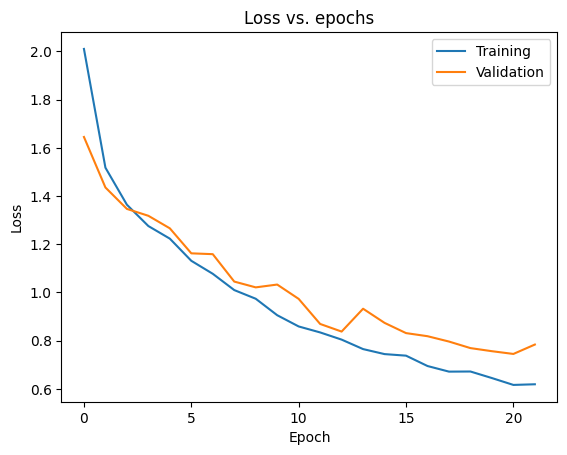

In [13]:
#Run this cell to plot the new loss vs epoch graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [14]:
#Evaluate the model on the test set (which is the same as the validation set for now)
test_acc = get_test_accuracy(model, x_test, y_test)

accuracy: 0.709


#### Create new instance of model and load on both sets of weights

In [15]:
"""
This function will create a new instance of the CNN created earlier,
load on the weights from the last training epoch, and return this model.
"""
def get_model_last_epoch(model):
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir="/checkpoint_every_epoch/"))

    return model

"""
This function will create a new instance of the CNN created earlier, load
on the weights leading to the highest validation accuracy, and return this model.
"""
def get_model_best_epoch(model):
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir="/checkpoint_best_only/"))

    return model


# Create two models: one with the weights from the last training epoch, and one with
# the weights leading to the highest validation (testing) accuracy. Verify that the
# second has a higher/equivalent validation (testing) accuarcy.
model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))

print('Model with last epoch weights:')
test_acc_last_epoch = get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
test_acc_best_epoch = get_test_accuracy(model_best_epoch, x_test, y_test)

Model with last epoch weights:
accuracy: 0.709

Model with best epoch weights:
accuracy: 0.725


In [16]:
# Define functions for evaluating model accuracy by class and overall
def eval_model_by_class(model, x_test, y_test):
    label_count = np.unique(y_test, return_counts = True)[1]
    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    y_test = [class_names[x] for x in y_test.reshape(-1)]
    y_pred = [class_names[x] for x in y_pred]

    pred_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
    pred_df = pred_df.groupby(['y_true']).sum().reset_index()
    pred_df['label_count'] = label_count
    pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
    pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
    pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
    pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

    return(pred_df)

eval_model_by_class(model_best_epoch, x_test, y_test)

32/32 [==============================] - 0s 3ms/step


<ipython-input-16-8f3e23105127>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,annual crop,72,90,0.800000,0.725
1,1,forest,93,96,0.968750,0.725
2,2,herbaceous vegetation,69,104,0.663462,0.725
3,3,highway,35,92,0.380435,0.725
4,4,industrial,80,91,0.879121,0.725
5,5,pasture,75,104,0.721154,0.725
6,6,permanent crop,70,110,0.636364,0.725
7,7,residential,84,106,0.792453,0.725
8,8,river,53,110,0.481818,0.725
9,9,seaLake,94,97,0.969072,0.725


32/32 [==============================] - 0s 3ms/step


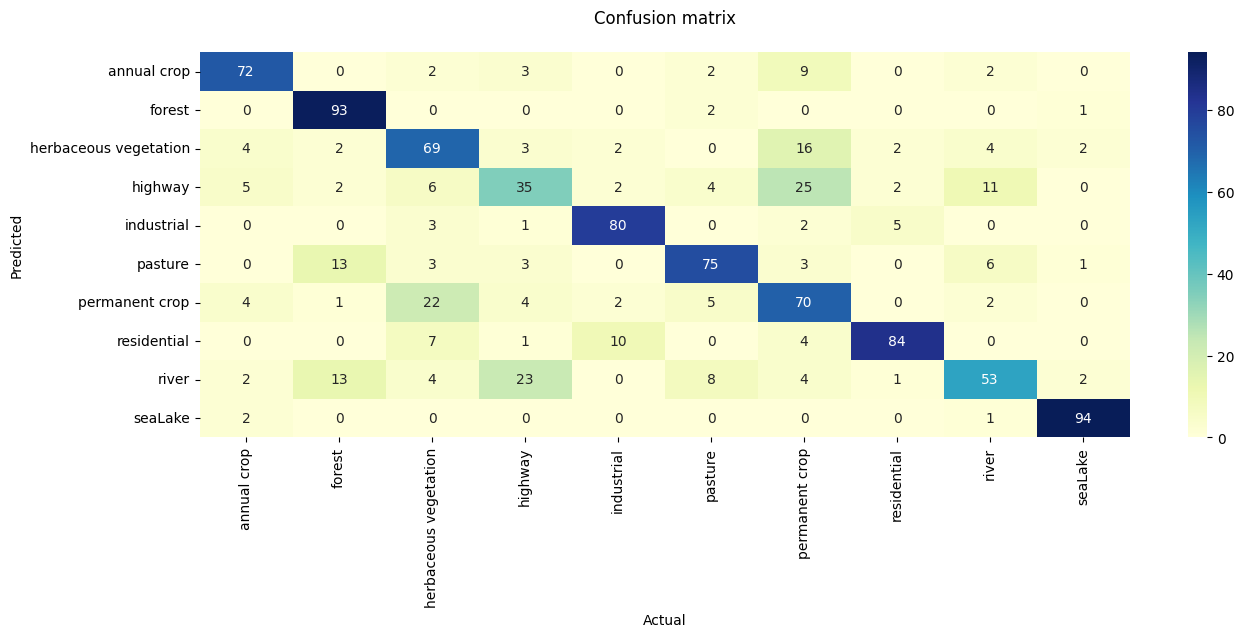

In [17]:
# Function to Plot confusion matrix
def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

# Plot confusion matrices for model_best_epoch
confMat(model_best_epoch, x_test, y_test)

### Time to amp up the performance

In [18]:
"""
This function will create a model derived from Resnet50.
    It will include all but the last layer of Resnet50 (essentially the output should have a shape of (None, 2048).
    It will the add a Dense layer with 64 units and RELU activation, a dropout layer with probability 0.5,
followed by output Dense layer with 10 units and Softmax activation.

Only the new layers added are trainable (all the layers of Resnet50 should be frozen).

The input shape of the Resnet50 is set using the input_shape argument, given by the
function argument.

The function will also compile the model with the Adam optimiser, a sparse categorical cross
entropy loss function, and a single accuracy metric.
"""
def get_TL_model(input_shape):
    # Get the resnet50 model
    resnet50_model = ResNet50(include_top=False, input_shape=input_shape, pooling="avg", classes=10)
    resnet50_model.trainable=False

    # Build final model
    model = Sequential([
        resnet50_model,
        Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        Dense(10, activation="softmax")
    ])

    # Compile the Model and Return
    adam = tf.keras.optimizers.legacy.Adam()
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

# Run the function and get the model
model_TL = get_TL_model(x_train[0].shape)
model_TL.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 23719498 (90.48 MB)
Trainable params: 131786 (514.79 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [19]:
'''
Pre-processes the Eurosat data using Resnet50 preprocessing function.
Returns the tupple of pre-processed training and test data.
'''
def get_preprocessed_input():
    # Reload the data
    x_train = np.load('data/x_train.npy')
    x_test  = np.load('data/x_test.npy')

    return (preprocess_input(x_train), preprocess_input(x_test))

x_train_resnet, x_test_resnet = get_preprocessed_input()

In [20]:
# Get the callbacks
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

# Fit the new model with the training data
new_history = model_TL.fit(x_train_resnet, y_train, epochs=50, validation_data=(x_test_resnet, y_test), callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.6420
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 10s 45ms/step - loss: 1.1627 - accuracy: 0.6420 - val_loss: 0.3799 - val_accuracy: 0.8800
Epoch 2/50
123/125 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.8211
Epoch 2: val_accuracy improved from 0.88000 to 0.89700, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 4s 29ms/step - loss: 0.5603 - accuracy: 0.8220 - val_loss: 0.3034 - val_accuracy: 0.8970
Epoch 3/50
124/125 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8586
Epoch 3: val_accuracy improved from 0.89700 to 0.90000, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 5s 39ms/step - loss: 0.4473 - accuracy: 0.8583 - val_loss: 0.3030 - val_accuracy: 0.9000
Epo

In [21]:
#Reload the model with the best epoch
model_TL_best_epoch = get_model_best_epoch(get_TL_model(x_train[0].shape))

print('TL Model with best epoch weights:')
test_acc_TL_best_epoch = get_test_accuracy(model_TL_best_epoch, x_test_resnet, y_test)

TL Model with best epoch weights:
accuracy: 0.930


In [22]:
eval_model_by_class(model_TL_best_epoch, x_test_resnet, y_test)

32/32 [==============================] - 1s 17ms/step


<ipython-input-16-8f3e23105127>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,annual crop,87,90,0.966667,0.93
1,1,forest,87,96,0.906250,0.93
2,2,herbaceous vegetation,97,104,0.932692,0.93
3,3,highway,74,92,0.804348,0.93
4,4,industrial,89,91,0.978022,0.93
5,5,pasture,103,104,0.990385,0.93
6,6,permanent crop,103,110,0.936364,0.93
7,7,residential,103,106,0.971698,0.93
8,8,river,95,110,0.863636,0.93
9,9,seaLake,92,97,0.948454,0.93


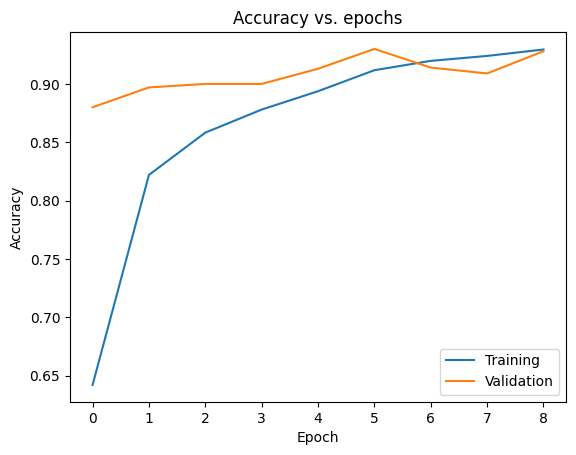

In [23]:
try:
    plt.plot(new_history.history['accuracy'])
    plt.plot(new_history.history['val_accuracy'])
except KeyError:
    plt.plot(new_history.history['acc'])
    plt.plot(new_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

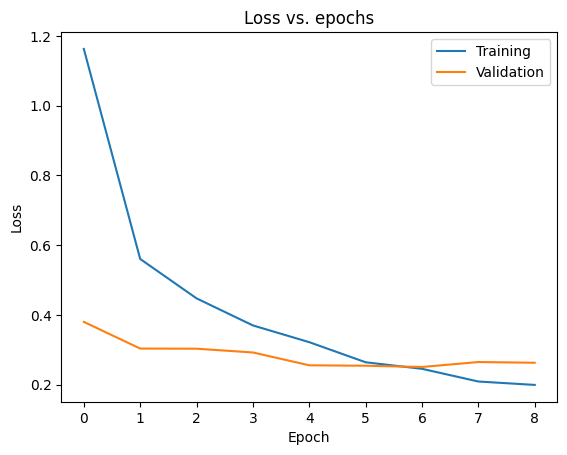

In [24]:
#Run this cell to plot the new loss vs epoch graph
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

32/32 [==============================] - 1s 17ms/step


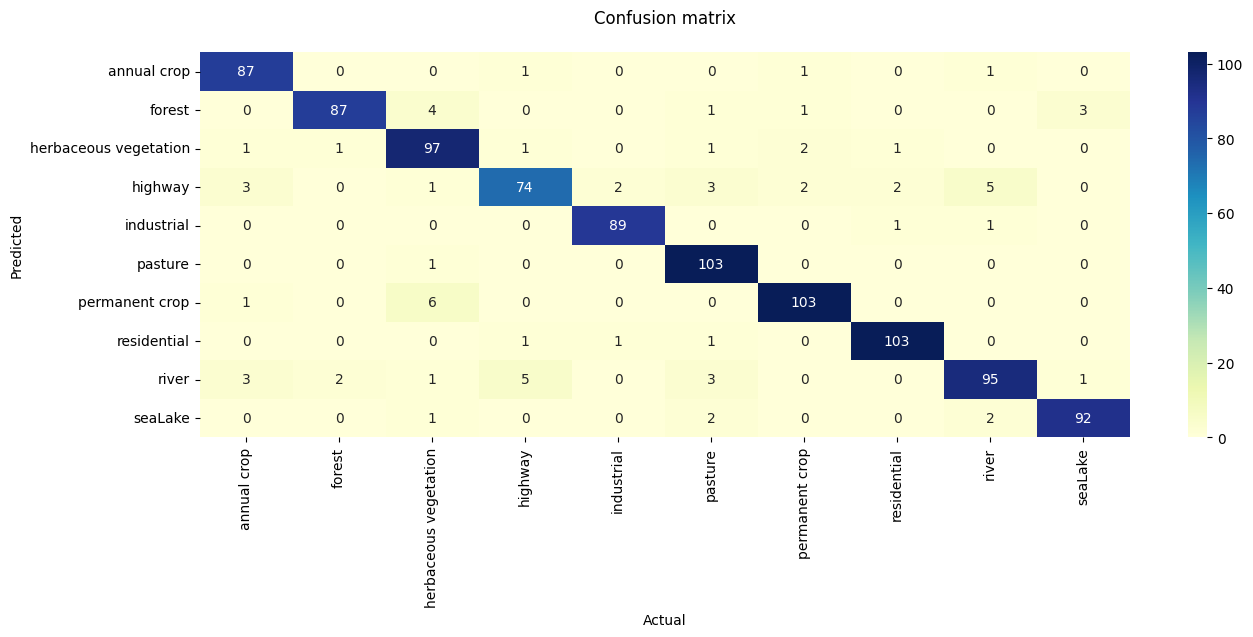

In [25]:
confMat(model_TL_best_epoch, x_test_resnet, y_test)

### Improve the performance further.

In [48]:
# Improve the model from before
def get_improved_TL_model(input_shape):
    wd=0.0001
    rate=0.5

    resnet50_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, pooling="max", classes=10)
    # Freeze the first 5 layers
    for layer in resnet50_model.layers[:5]:
      layer.trainable=False

    # Construct the new model
    inputs = resnet50_model.input
    x = Dense(100, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dense(10, activation="softmax")(x)
    outputs = Dense(10, activation="softmax")(resnet50_model.layers[-1].output)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the Model and Return
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005, weight_decay=wd)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

# Get the new model
new_model_TL = get_improved_TL_model(x_train[0].shape)

In [49]:
# Get the Callbacks
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
reduceLROnP = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, min_lr=0.0000001)
callbacks = [checkpoint_best_only, early_stopping, reduceLROnP]

# Fit the improved model with the training data
new_improved_history = new_model_TL.fit(x_train_resnet, y_train, epochs=50, validation_data=(x_test_resnet, y_test), callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.7915
Epoch 1: val_accuracy improved from -inf to 0.36700, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 89s 453ms/step - loss: 1.0821 - accuracy: 0.7915 - val_loss: 1486.2231 - val_accuracy: 0.3670 - lr: 5.0000e-04
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 1.1750 - accuracy: 0.8690
Epoch 2: val_accuracy improved from 0.36700 to 0.76100, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 64s 519ms/step - loss: 1.1750 - accuracy: 0.8690 - val_loss: 28.3328 - val_accuracy: 0.7610 - lr: 5.0000e-04
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.9057
Epoch 3: val_accuracy improved from 0.76100 to 0.87200, saving model to /checkpoint_best_only/checkpoint
125/125 [==============================] - 73s 586ms/step - loss: 0.6077 - accuracy: 0.9057 - 

TL Model with best epoch weights:
accuracy: 0.960
32/32 [==============================] - 1s 14ms/step


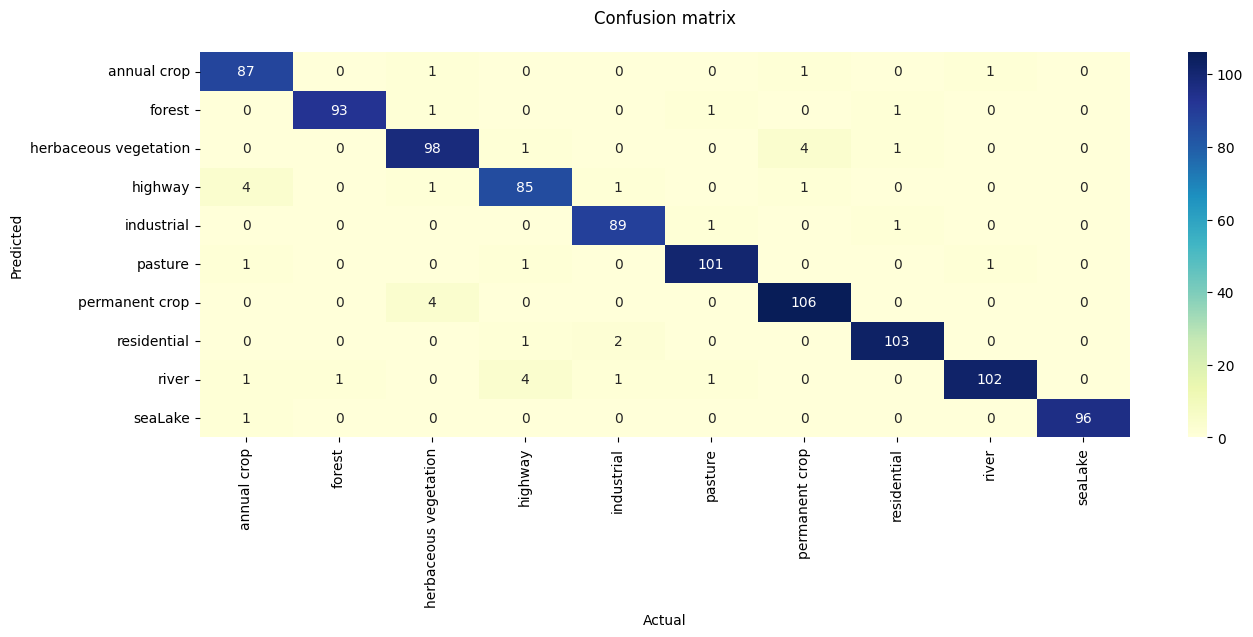

In [50]:
#Reload the model with the best epoch
model_TL_best_epoch = get_model_best_epoch(get_improved_TL_model(x_train[0].shape))

print('TL Model with best epoch weights:')
test_acc_TL_best_epoch = get_test_accuracy(model_TL_best_epoch, x_test_resnet, y_test)

confMat(model_TL_best_epoch, x_test_resnet, y_test)

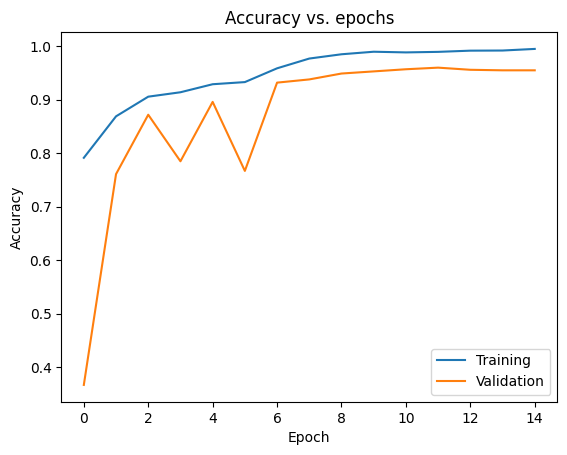

In [51]:
try:
    plt.plot(new_improved_history.history['accuracy'])
    plt.plot(new_improved_history.history['val_accuracy'])
except KeyError:
    plt.plot(new_improved_history.history['acc'])
    plt.plot(new_improved_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

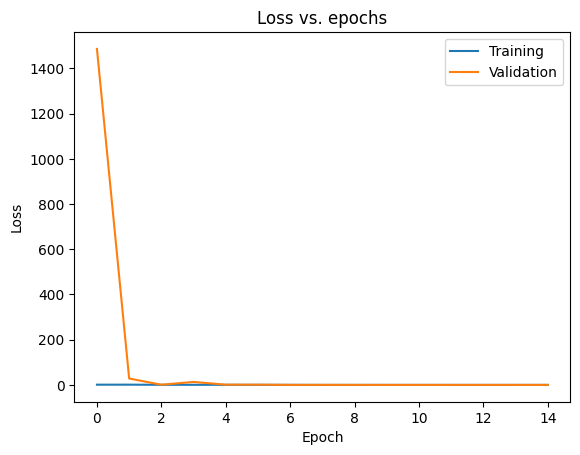

In [52]:
#Run this cell to plot the new loss vs epoch graph
plt.plot(new_improved_history.history['loss'])
plt.plot(new_improved_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()